# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from data_clean import portfolio_data_clean, profile_data_clean, transcript_data_clean
from data_merge import combine_data
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. EDA & Data preprocessing 

### 1.1. Portfolio dataset

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
print("Portfolio dataset contains {} variables and {} rows".format(portfolio.shape[1],portfolio.shape[0]))

Portfolio dataset contains 6 variables and 10 rows


According with the documentations above, this **portfolio dataset** contains the following information
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


There are no null values and variable types are as expected. This dataset needs to be preproccesed, applying the following changes:<br>
- rename `id` column to `offerid`
- one hot encode the `offer_type` column
- one hot encode the `channels` column

In [5]:
#let's clen portfolio df
portfolio_clean = portfolio_data_clean(portfolio)
portfolio_clean

,difficulty,duration,offerid,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


### 1.2. Profile dataset

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
print("Profile dataset contains {} variables and {} rows".format(profile.shape[1],profile.shape[0]))

Profile dataset contains 5 variables and 17000 rows


According with the documentations above, this **profile dataset** contains the following information
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


It seems we have null values in `gender` and `income` variables

In [9]:
print("Number of null values in gender variable is {}.".format(np.sum(profile.gender.isnull())))
print("Number of null values in income variable is {}.".format(np.sum(profile.income.isnull())))

Number of null values in gender variable is 2175.
Number of null values in income variable is 2175.


We see that `became_member_on` (suposed to be a datetime variable) is an integer

In [10]:
profile.became_member_on.dtypes

dtype('int64')

- **`gender` variable**

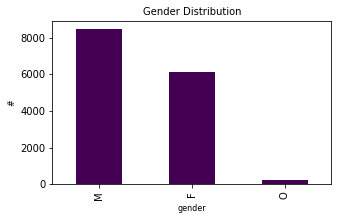

In [11]:
plt.title('Gender Distribution', size=10)
plt.ylabel('#', size=8)
plt.xlabel('gender', size=8)
profile.gender.value_counts().plot(kind='bar',cmap="viridis", figsize=(5, 3))

In [12]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

where M = Male, F = Female and O = Other 

- **`age` and `income` variables**

In [13]:
profile[['age','income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


We see as `max` age **118 years**, being age `median` **58 years**.<br>
According to my experience going to starbucks, this is not very usual. Let's see age distribution in a histogram:

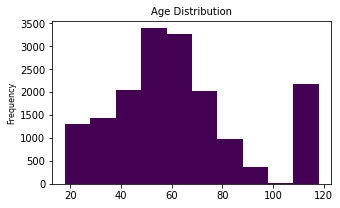

In [14]:
plt.title('Age Distribution', size=10)
plt.ylabel('Frecuency', size=8)
profile['age'].plot(kind='hist',cmap="viridis", figsize=(5, 3))

There are over 2000 customers which age es over 100 years

In [15]:
profile[['age','id']].groupby('age').count().reset_index().rename(columns={'id': 'count'}).tail()

,age,count
80,98,5
81,99,5
82,100,12
83,101,5
84,118,2175


We have 2175 customers which age is 118. This number of customers coincides with gender and income null values. Let's confirm if 118 aged customers have no gender and income detailed:

In [16]:
profile[profile['age']==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [17]:
print("Number of null values in gender variable with 118 years old customers is {}.".format(np.sum(profile[profile['age']==118].gender.isnull())))
print("Number of null values in income variable with 118 years old customers is {}.".format(np.sum(profile[profile['age']==118].income.isnull())))

Number of null values in gender variable with 118 years old customers is 2175.
Number of null values in income variable with 118 years old customers is 2175.


We need to drop these rows from the dataset.<br><br>
Let's now take a look at Income variable:

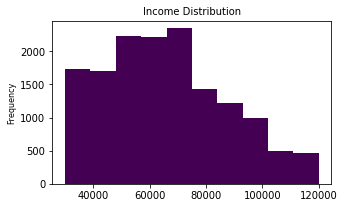

In [18]:
#Income distribution
plt.title('Income Distribution', size=10)
plt.ylabel('Frecuency', size=8)
profile['income'].plot(kind='hist',cmap="viridis", figsize=(5, 3))

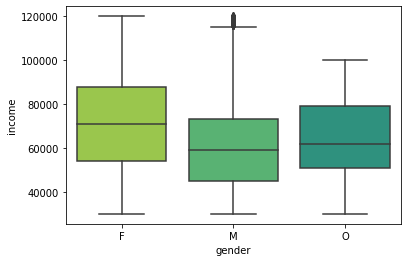

In [19]:
#Income distribution by gender
sns.set_palette("viridis_r")
sns.boxplot(y='income', x= 'gender',data=profile)

Profile dataset needs to be preproccesed, applying the following changes:<br>
- rename `id` column to `customerid`
- one hot encode the `gender` column
- drop rows with null values on `income` and `gender` variables (those with 118 in `age` variable)
- convert `became_member_on` to datetime values.
- one hot encode new `year_became_member` variable.
- one hot encode new `weekday_became_member` variable.
- split `ages` in 10 years bins and one hot encode it

In [20]:
#let's clen profile df
profile_clean = profile_data_clean(profile)

In [21]:
profile_clean.head()

,age,became_member_on,gender,customerid,income,year_became_member,month_became_member,weekday_became_member,weekday_became_member_cat,month_became_member_cat,...,81-90,91-100,100-110,weekda_bm_Mon,weekda_bm_Tue,weekda_bm_Wed,weekda_bm_Thu,weekda_bm_Fri,weekda_bm_Sat,weekda_bm_Sun
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,5,Sat,Jul,...,0,0,0,0,0,0,0,0,1,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,Tue,May,...,0,0,0,0,1,0,0,0,0,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,3,Thu,Apr,...,0,0,0,0,0,0,1,0,0,0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,4,Fri,Feb,...,0,0,0,0,0,0,0,1,0,0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,5,Sat,Nov,...,0,0,0,0,0,0,0,0,1,0


In [22]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 37 columns):
age                          14825 non-null int64
became_member_on             14825 non-null datetime64[ns]
gender                       14825 non-null object
customerid                   14825 non-null object
income                       14825 non-null float64
year_became_member           14825 non-null int64
month_became_member          14825 non-null int64
weekday_became_member        14825 non-null int64
weekday_became_member_cat    14825 non-null category
month_became_member_cat      14825 non-null category
age_bins                     14825 non-null category
gender_F                     14825 non-null uint8
gender_M                     14825 non-null uint8
gender_O                     14825 non-null uint8
year_bm_2013                 14825 non-null uint8
year_bm_2014                 14825 non-null uint8
year_bm_2015                 14825 non-null uint8
year_bm_2016       

Text(0.5, 0, 'Year Month')

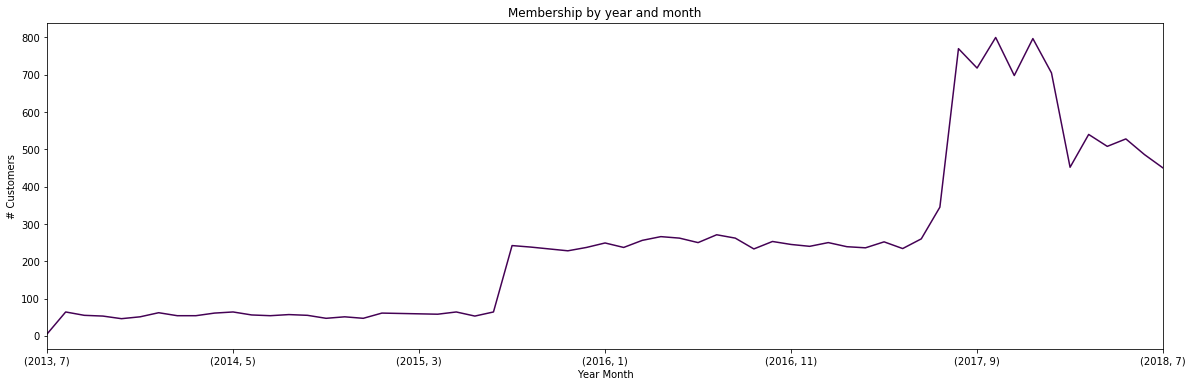

In [23]:
#New members by year month 
plt.figure(figsize = (14,6))
profile_clean.groupby(['year_became_member','month_became_member'])['customerid'].count().plot(cmap="viridis", figsize=(20, 6))
plt.title('Membership by year and month')
plt.ylabel('# Customers', size=10)
plt.xlabel('Year Month', size=10)

We see a pike in the 4th Q of 2017; new member have been increasing since 2013. Let's see now the proportion of new members by year:

In [24]:
profile_clean.groupby(['year_became_member'])['customerid'].count()/profile_clean.shape[0]

year_became_member
2013    0.018482
2014    0.044654
2015    0.107723
2016    0.203980
2017    0.377673
2018    0.247487
Name: customerid, dtype: float64

New members have been increasing a 100% year by year. Even though we have no data for all 2018 (only untill July), it seems that the growth in 2018 will not be as good as past years (24.8% of new members).

Text(0.5, 0, 'Year Month')

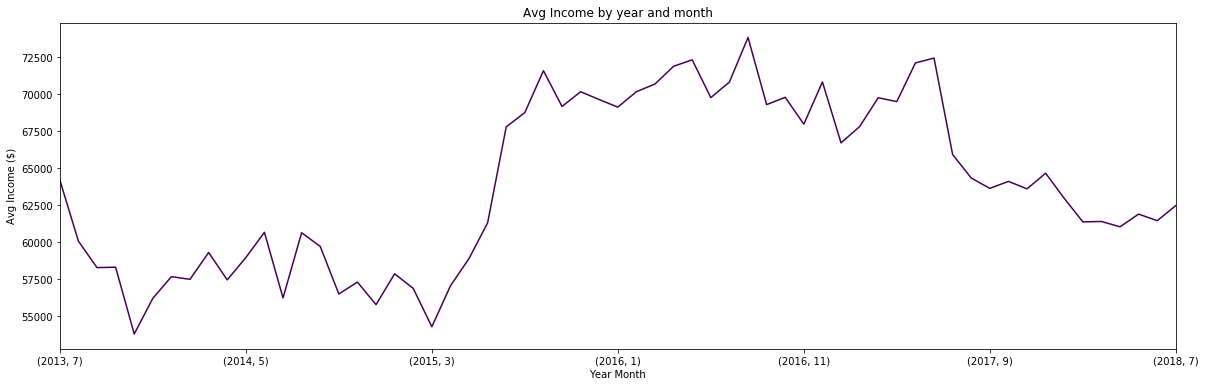

In [25]:
#Avg income by year month 
plt.figure(figsize = (14,6))
profile_clean.groupby(['year_became_member','month_became_member'])['income'].mean().plot(cmap="viridis", figsize=(20, 6))
plt.title('Avg Income by year and month')
plt.ylabel('Avg Income ($)', size=10)
plt.xlabel('Year Month', size=10)

Average income has increased through the years until mid 2017:

In [26]:
profile_clean.groupby(['year_became_member'])['income'].mean()

year_became_member
2013    57664.233577
2014    58200.906344
2015    67072.010019
2016    70592.592593
2017    65685.479550
2018    61853.638594
Name: income, dtype: float64

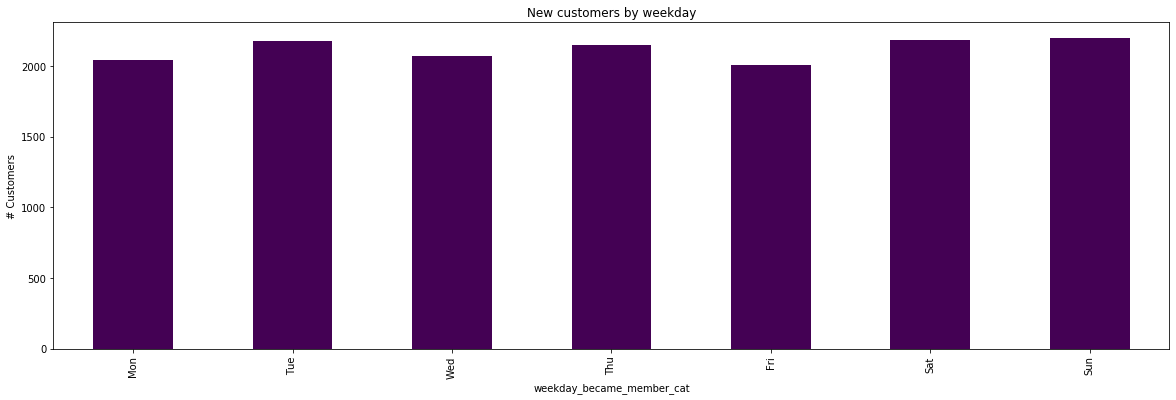

In [27]:
#New customers by weekday 
plt.figure(figsize = (6,3))
plt.title('New customers by weekday')
plt.ylabel('# Customers', size=10)
plt.xlabel('Day of the week', size=10)
profile_clean.groupby(['weekday_became_member_cat'])['customerid'].count().plot(kind='bar',cmap="viridis", figsize=(20, 6))

According to the visual. It seems that weekends, tuesdays and thursdays are the best days to become a new customer.

In [28]:
profile_clean.groupby(['weekday_became_member_cat'])['customerid'].count()/profile_clean.shape[0]

weekday_became_member_cat
Mon    0.137605
Tue    0.147049
Wed    0.139562
Thu    0.144890
Fri    0.135245
Sat    0.147319
Sun    0.148331
Name: customerid, dtype: float64

Let's represent new customers vs month and weekday on a heatmap:

In [29]:
day_month_member = pd.DataFrame(profile_clean.groupby(['month_became_member_cat', 'weekday_became_member_cat']).count()['customerid']).reset_index()
day_month_member = day_month_member.pivot('month_became_member_cat','weekday_became_member_cat','customerid')

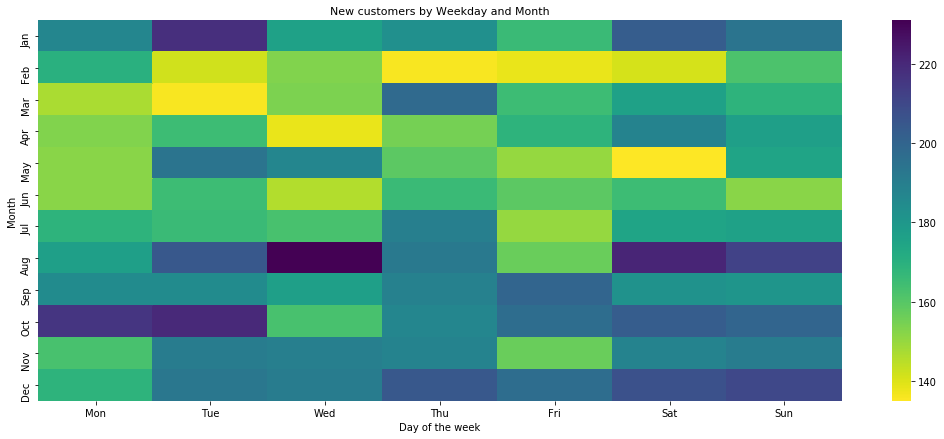

In [30]:
plt.figure(figsize=(18,7))
sns.heatmap(day_month_member, cmap = 'viridis_r')
plt.title('New customers by Weekday and Month', size=11)
plt.ylabel('Month', size=10)
plt.xlabel('Day of the week', size=10)
plt.show()

We see that we have more new customers on weekends across the year, being the period between august and december the best months in general <br>
Let's see now the differences between genders and salaries:

In [31]:
#gender proportion
profile_clean.groupby(['gender'])['customerid'].count()/profile_clean.shape[0]

gender
F    0.413423
M    0.572277
O    0.014300
Name: customerid, dtype: float64

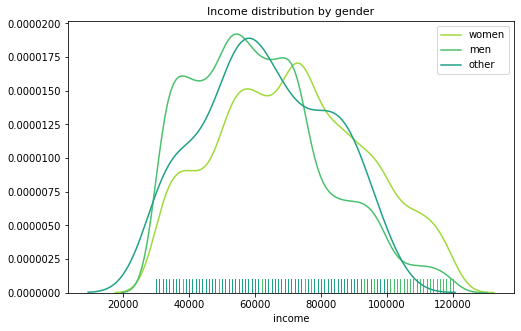

In [32]:
men = profile_clean[profile_clean['gender_M'] == 1]
women = profile_clean[profile_clean['gender_F'] == 1]
other = profile_clean[profile_clean['gender_O'] == 1]

sns.set_palette("viridis_r")
fig = plt.subplots(figsize=(8, 5))
plt.title('Income distribution by gender', size=11)

sns.distplot(women['income'], hist=False, rug=True, label='women')
sns.distplot(men['income'], hist=False, rug=True, label='men')
sns.distplot(other['income'], hist=False, rug=True, label='other')

plt.legend()

In [33]:
print(profile_clean.groupby(['gender'])['income'].mean())

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64


In [34]:
print(profile_clean.groupby(['gender'])['income'].median())

gender
F    71000.0
M    59000.0
O    62000.0
Name: income, dtype: float64


As we see in the graph, complemented by median and mean values, wee see that incomes are normal distributed

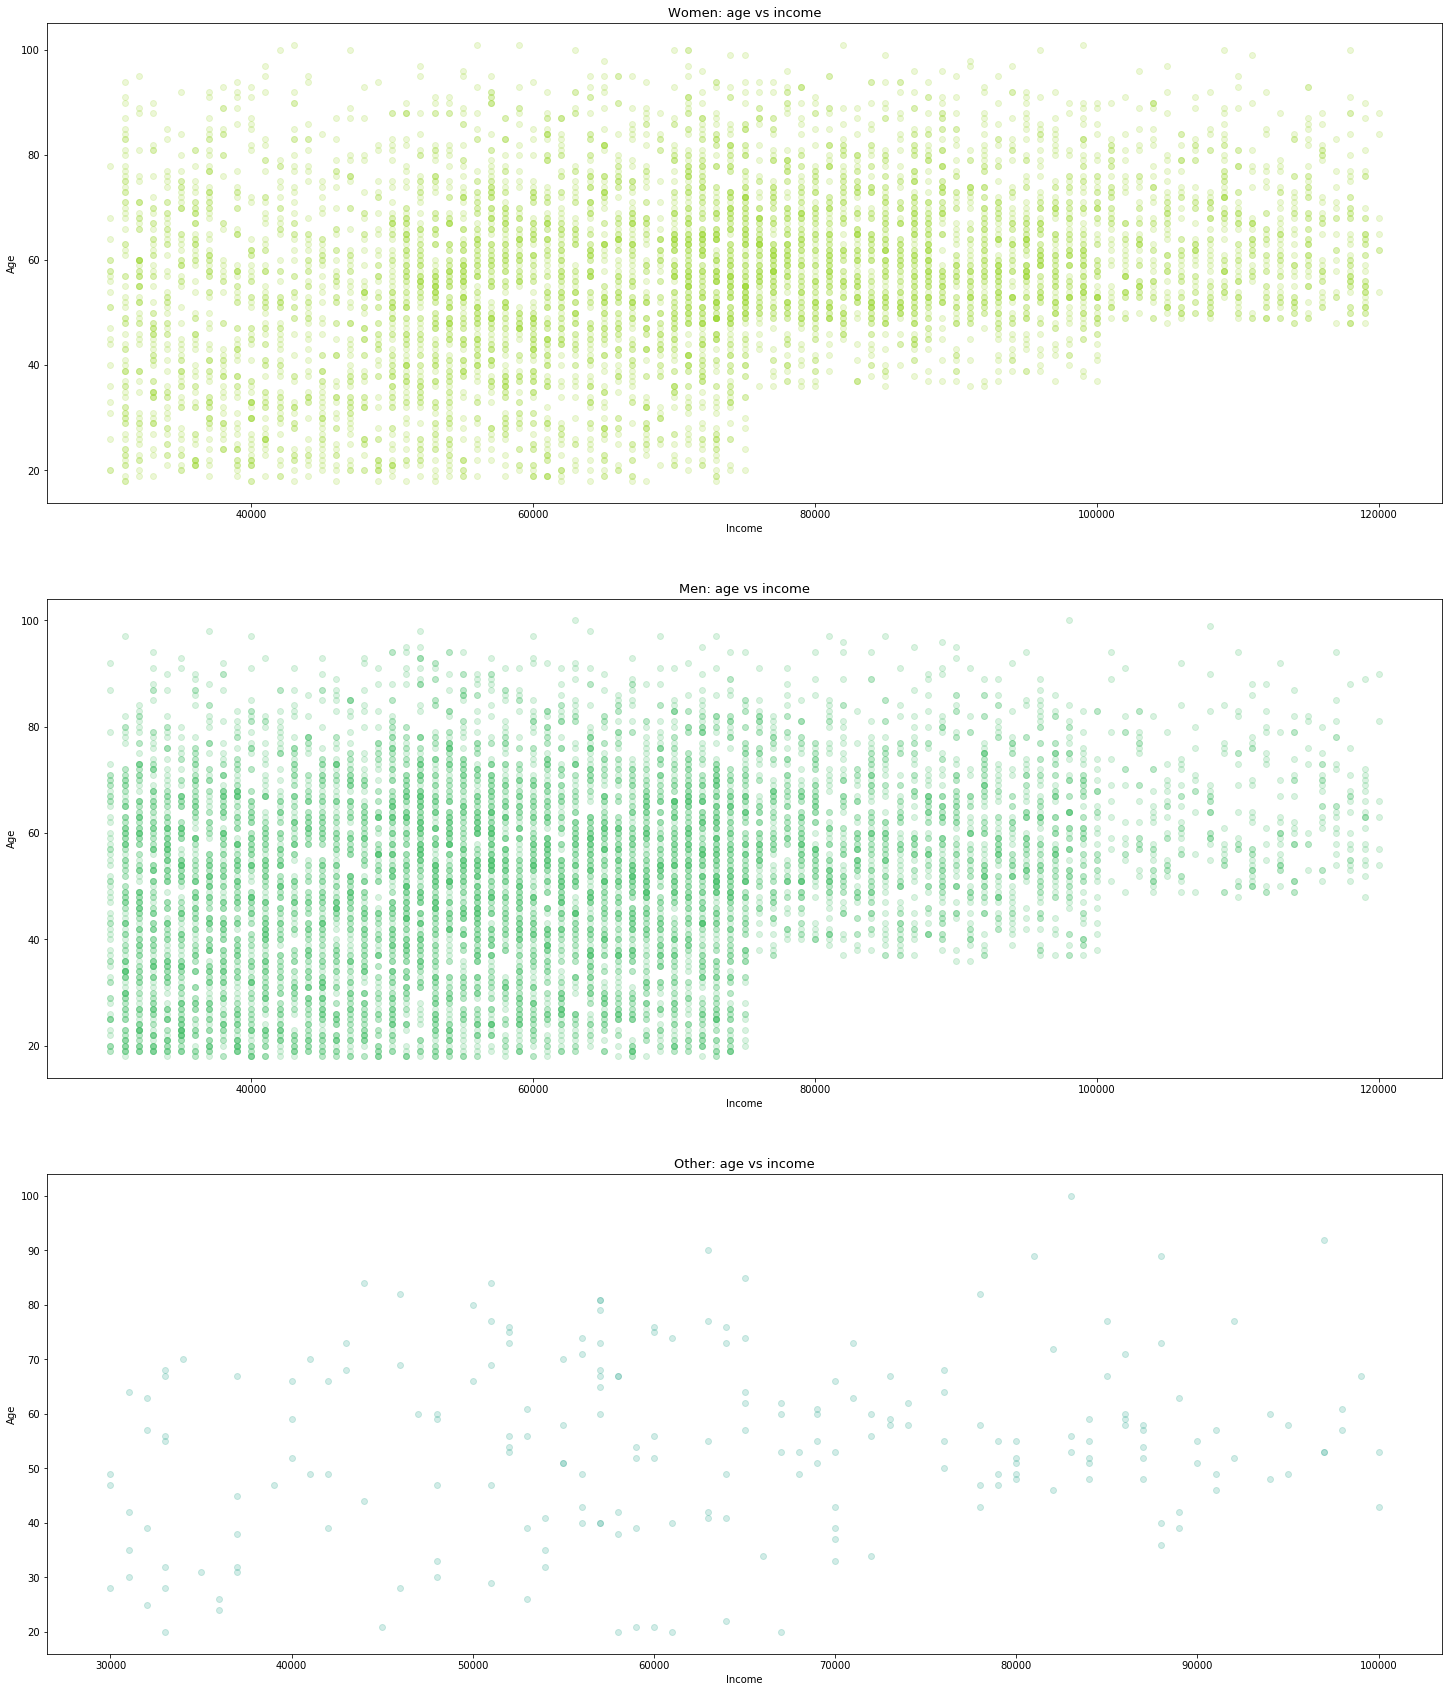

In [35]:
sns.set_palette("viridis_r")
plt.figure(figsize=(25,30))

plt.subplot(3, 1, 1) # 1 row, 3 cols, subplot 1
ax = plt.scatter(women['income'], women['age'], color = sns.color_palette()[0],  alpha=0.2, label="women")
plt.title('Women: age vs income', size=13)
plt.ylabel('Age', size=10)
plt.xlabel('Income', size=10)


plt.subplot(3, 1, 2) # 1 row, 3 cols, subplot 2
base_color = sns.color_palette()[1]
ax = plt.scatter(men['income'], men['age'], color = sns.color_palette()[1], alpha=0.2, label="men")
plt.title('Men: age vs income', size=13)
plt.ylabel('Age', size=10)
plt.xlabel('Income', size=10)

plt.subplot(3, 1, 3) # 1 row, 3 cols, subplot 3
base_color = sns.color_palette()[2]
ax = plt.scatter(other['income'], other['age'], color = sns.color_palette()[2], alpha=0.2, label="other")
plt.title('Other: age vs income', size=13)
plt.ylabel('Age', size=10)
plt.xlabel('Income', size=10)

plt.show()

Even though there are less Female customers, we see that higher incomes concentred in females which age is > 45 years. <br>
Let's compare now the avg income grouped by age and gender:

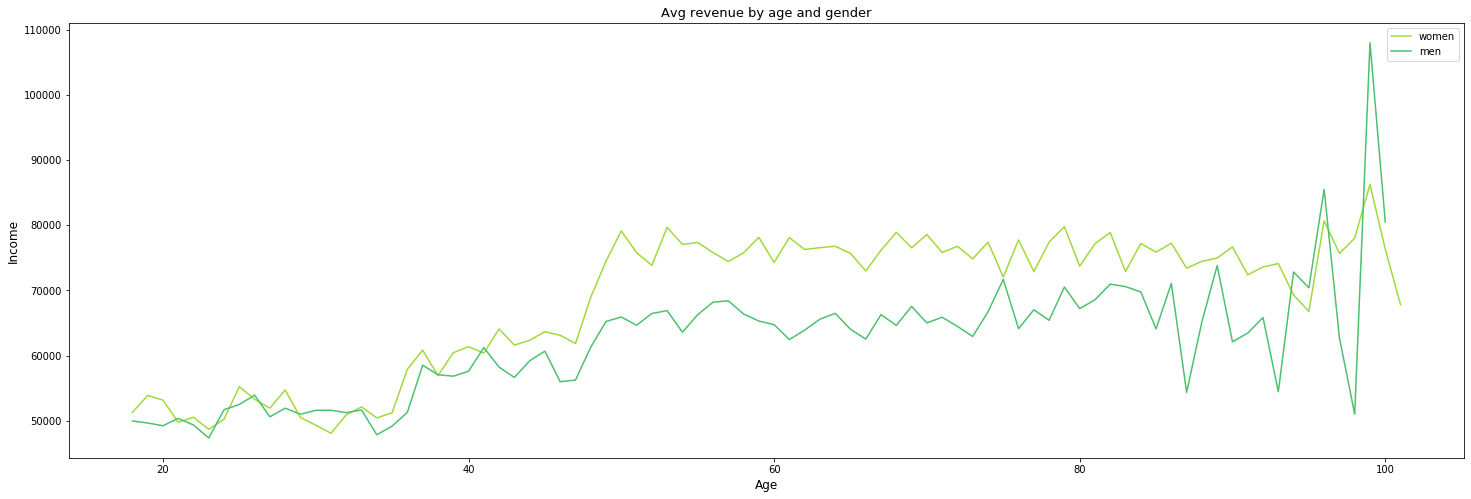

In [36]:
#Data for Other gender is not representative. In order to compare income with age and gender, Other value attribute 
#not be included

women_inc_avg = pd.DataFrame(women.groupby(['age']).mean()['income']).reset_index()
men_inc_avg = pd.DataFrame(men.groupby(['age']).mean()['income']).reset_index()
othr_inc_avg = pd.DataFrame(other.groupby(['age']).mean()['income']).reset_index()

sns.set_palette("viridis_r")
plt.figure(figsize=(25,8))
plt.plot(women_inc_avg['age'], women_inc_avg['income'], label="women")
plt.plot(men_inc_avg['age'], men_inc_avg['income'], label="men")
#plt.plot(othr_inc_avg['age'], othr_inc_avg['income'], label="other")
plt.title('Avg revenue by age and gender',size=13)
plt.xlabel('Age', size=12)
plt.ylabel('Income',size=12)

plt.legend()

- As expected, we see higher salaries for women. 
- We see also an increase for those who have more than 45 years old. 
- It seems whe have some outliers, that will be seen later.

Let's see the distribution of gender new members over the years

Text(0, 0.5, '# New members')

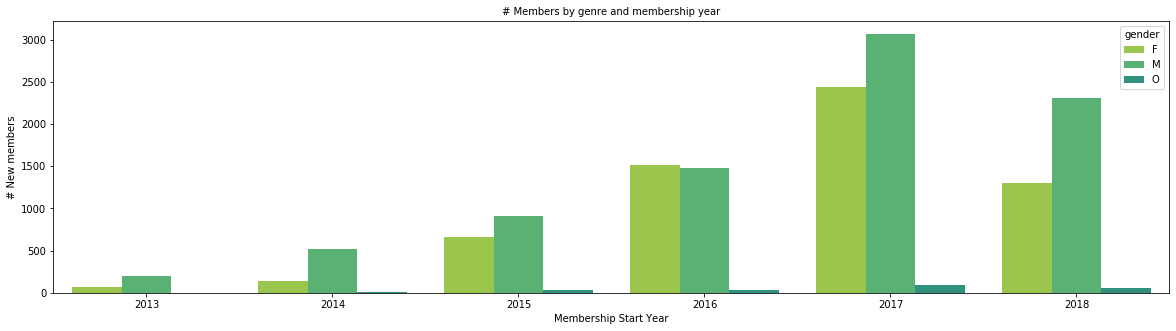

In [37]:
gender_year = pd.DataFrame(profile_clean.groupby(['year_became_member','gender']).count()['customerid']).reset_index()
gender_year.columns = ['became_member_year','gender', 'count']

plt.figure(figsize=(20, 5))
sns.barplot(x='became_member_year', y='count', hue='gender', data=gender_year)
plt.title('# Members by genre and membership year',size=10)
plt.xlabel('Membership Start Year', size=10)
plt.ylabel('# New members',size=10)


In [38]:
#detail: % over total by year

genre_year = pd.DataFrame(profile_clean.groupby(['year_became_member','gender']).count()['customerid'])
genre_year_pcts = genre_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
genre_year_pcts = genre_year_pcts.rename(columns={'customerid': '% over year'})
genre_year_pcts.unstack()

% over year                     
gender                       F          M         O
year_became_member                                 
2013                 27.007299  71.897810  1.094891
2014                 20.845921  78.549849  0.604230
2015                 41.515341  56.668754  1.815905
2016                 49.900794  49.041005  1.058201
2017                 43.632792  54.777639  1.589570
2018                 35.486509  63.014445  1.499046

There are more new male members than new female members. <br>
Let's see now  distribution of members by age

Text(0, 0.5, '# New members')

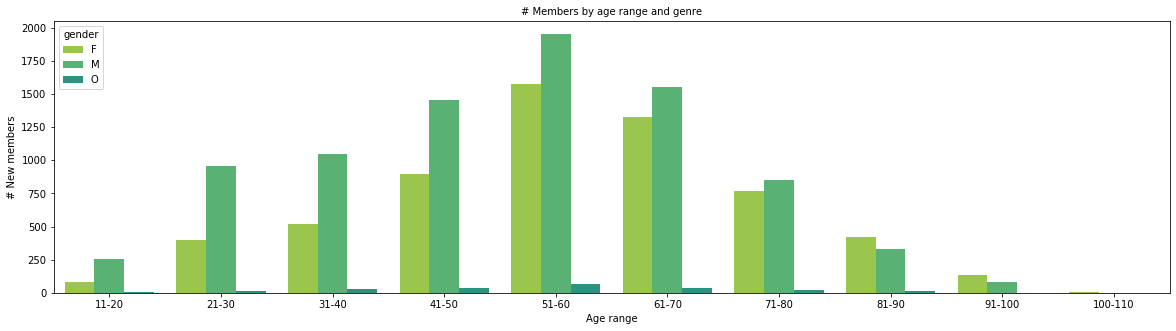

In [39]:
gender_age_bins = pd.DataFrame(profile_clean.groupby(['age_bins','gender']).count()['customerid']).reset_index()
gender_age_bins.columns = ['age_bin','gender', 'count']

plt.figure(figsize=(20, 5))
sns.barplot(x='age_bin', y='count', hue='gender', data=gender_age_bins)
plt.title('# Members by age range and genre',size=10)
plt.xlabel('Age range', size=10)
plt.ylabel('# New members',size=10)


In [40]:
#detail: % over total by year

genre_age_bin = pd.DataFrame(profile_clean.groupby(['age_bins','gender']).count()['customerid'])
genre_age_bin = genre_age_bin.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
genre_age_bin_pct = genre_age_bin.rename(columns={'customerid': '% over age bin'})
genre_age_bin_pct.unstack()

% over age bin                     
gender                F          M         O
age_bins                                    
11-20         23.529412  75.294118  1.176471
21-30         29.157509  69.816850  1.025641
31-40         32.686287  65.685661  1.628053
41-50         37.557507  60.936847  1.505646
51-60         43.844011  54.401114  1.754875
61-70         45.601375  53.230241  1.168385
71-80         46.840826  51.761847  1.397327
81-90         55.149935  43.546284  1.303781
91-100        61.214953  37.850467  0.934579
100-110      100.000000        NaN       NaN

### 1.3. Transcript dataset

In [41]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [42]:
print("Transcript dataset contains {} variables and {} rows".format(transcript.shape[1],transcript.shape[0]))

Transcript dataset contains 4 variables and 306534 rows


According with the documentations above, this **transcript dataset** contains the following information:
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [43]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No null values

- Came of the 'person' column to 'customerid'
- Remove customer id's that are not in the customer profile DataFrame
- Convert time variable units from hours to days
- Change the name of the 'time' column to 'timedays'
- Create a DataFrame that describes offers
- Create an offerid column
- Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
- One hot encode customer offer events
- Create a DataFrame that describes customer transaction events
- Parse customer transaction values

- **`person` variable**

In [44]:
# number of unique customers on dataset
transcript_unq = transcript.person.nunique()
print("Transcript dataset contains {} unique customers".format(transcript_unq))

#Let's compare with unique customers in profile_clean df
profile_unq = profile_clean.customerid.nunique()
print("Profile clean dataset contains {} unique customers".format(profile_unq))

Transcript dataset contains 17000 unique customers
Profile clean dataset contains 14825 unique customers


- We see differences on number of unique customers between profile and transcript clean. 
- We should keep in transcript df only those who exist in profile df 

In [45]:
#Let's confirm that all customers in profile exist in transcript 
transcript[transcript['person'].isin(profile_clean['customerid'])==True].person.nunique() == profile_unq

True

- **`time` variable**

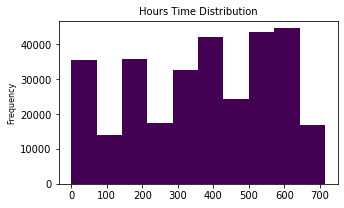

In [46]:
plt.title('Hours Time Distribution', size=10)
plt.ylabel('Frecuency', size=8)
transcript['time'].plot(kind='hist',cmap="viridis", figsize=(5, 3))

`time` variable units have to be converted from hours to days to be consistent with portolio dataset

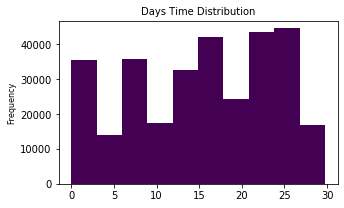

In [47]:
days_var = transcript['time']/24
plt.title('Days Time Distribution', size=10)
plt.ylabel('Frecuency', size=8)
days_var.plot(kind='hist',cmap="viridis", figsize=(5, 3))

In [48]:
days_var.describe()

count    306534.000000
mean         15.265956
std           8.346930
min           0.000000
25%           7.750000
50%          17.000000
75%          22.000000
max          29.750000
Name: time, dtype: float64

- **`event` variable**

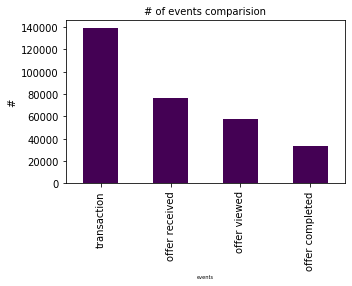

In [49]:
plt.title('# of events comparision', size=10)
plt.ylabel('#', size=10)
plt.xlabel('events', size=5)
transcript.event.value_counts().plot(kind='bar',cmap="viridis", figsize=(5, 3))

In [50]:
transcript.event.value_counts()/transcript.shape[0]

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

We see that there are 45% of events as transactions, 25% of events as offers received, 19% of events as offers viewed and 10 % of events as offers completed. We need to separate events with type `transactions` and `offers` to be used later for analysis.

- **`value` variable**

Can be either an offer id or transaction amount depending on the record.

In [51]:
transcript[transcript['event'] == 'transaction'].value.head(10)

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
12678                  {'amount': 33.9}
12686                  {'amount': 0.22}
12687                 {'amount': 18.59}
12691                 {'amount': 18.01}
12696                 {'amount': 19.11}
Name: value, dtype: object

In [52]:
transcript[transcript['event'] != 'transaction'].value.head(10)

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, dtype: object

Let's check if we have all the offers expected from portfolio df

In [53]:
# Extracting offer_id from value variable
def offerid(x):
    for key,value in x.items():
        if key in ['offer id','offer_id']:
            return str(value)

transcript_eda = transcript.copy()        
# Create column 'offer_id' and applying the function offer_id
transcript_eda['offerid'] = transcript_eda['value'].apply(offerid)

In [54]:
print('Number of offers extracted ',transcript_eda[transcript_eda['event'] != 'transaction'].offerid.nunique())

Number of offers extracted  10


Let's now check if the offers are the same than in portfolio df

In [55]:
len(set(portfolio_clean['offerid'] + transcript_eda[transcript_eda['event'] != 'transaction'].offerid.unique()))

10

We need to split transcipt dataset in two:
    1. offer_data (transcript(transcript['event'] != 'transaction'])
    2. transaction_data (transcript(transcript['event'] == 'transaction'])

Transcript dataset needs to be preproccesed, applying the following changes:<br>
- rename `person` column to `customerid`
- convert `time` variable units from hours to days to be consistent with portolio dataset
- drop rows of customers that are not contained in profile_clean df
- create `offerid` column (from `value` variable where events are not equal to transaction)
- create `amount` column (from `value` variable where events are not equal to transaction)
- Split transcript dataset in two different datasets:
    - offer_data: `offerid`|`customerid`|`time`|`event`(ohe)
    - transaction_data `customerid`|`time`|`amount`


In [56]:
offer_data, transaction_data = transcript_data_clean(transcript,profile_clean)

C:\Users\marco\Documents\Formación\Udacity\Udacity Data Scientist Nanodegree\3. Entregables\4. Capstone project\data_clean.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  offer_data['offerid'] = offer_data['value'].apply(offerid)
C:\Users\marco\Documents\Formación\Udacity\Udacity Data Scientist Nanodegree\3. Entregables\4. Capstone project\data_clean.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  transaction_data['amount'] = transaction_data['value'].apply(amount)


#### 1.3.1. offer_data dataset

In [57]:
offer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 306527
Data columns (total 6 columns):
offerid            148805 non-null object
customerid         148805 non-null object
time               148805 non-null float64
offer received     148805 non-null uint8
offer viewed       148805 non-null uint8
offer completed    148805 non-null uint8
dtypes: float64(1), object(2), uint8(3)
memory usage: 10.0+ MB


In [58]:
print("Offer_data dataset contains {} variables and {} rows".format(offer_data.shape[1],offer_data.shape[0]))

Offer_data dataset contains 6 variables and 148805 rows


In [59]:
offer_data.head()

,offerid,customerid,time,offer received,offer viewed,offer completed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,1,0,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,1,0,0
5,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,1,0,0
7,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,1,0,0
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,1,0,0


In [60]:
offer_data.nunique()

offerid               10
customerid         14820
time                 120
offer received         2
offer viewed           2
offer completed        2
dtype: int64

- **`time` variable**

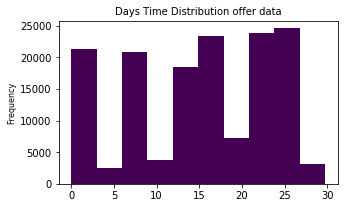

In [61]:
plt.title('Days Time Distribution offer data', size=10)
plt.ylabel('Frecuency', size=8)
offer_data.time.plot(kind='hist',cmap="viridis", figsize=(5, 3))

In [62]:
offer_data.time.describe()

count    148805.000000
mean         14.773759
std           8.262971
min           0.000000
25%           7.000000
50%          17.000000
75%          21.250000
max          29.750000
Name: time, dtype: float64

- **`offers` variable**

In [63]:
offers_unpivot = pd.melt(offer_data, id_vars=['offerid','customerid','time'], var_name='status', value_name='value')
offers_unpivot = offers_unpivot[offers_unpivot['value']==1]
offers_unpivot['offer_desc'] = offers_unpivot['offerid'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 'offer 1',\
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'offer_2',\
                                                               '3f207df678b143eea3cee63160fa8bed': 'offer_3',\
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'offer_4',\
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'offer_5',\
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'offer_6',\
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'offer_7',\
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'offer_8',\
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'offer_9',\
                                                               '2906b810c7d4411798c6938adc9daaa5': 'offer_10'})
offers_unpivot.head()

,offerid,customerid,time,status,value,offer_desc
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,offer received,1,offer_4
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,offer received,1,offer_10
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,offer received,1,offer_9
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,offer received,1,offer_3
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,offer received,1,offer_5


Text(0, 0.5, '#')

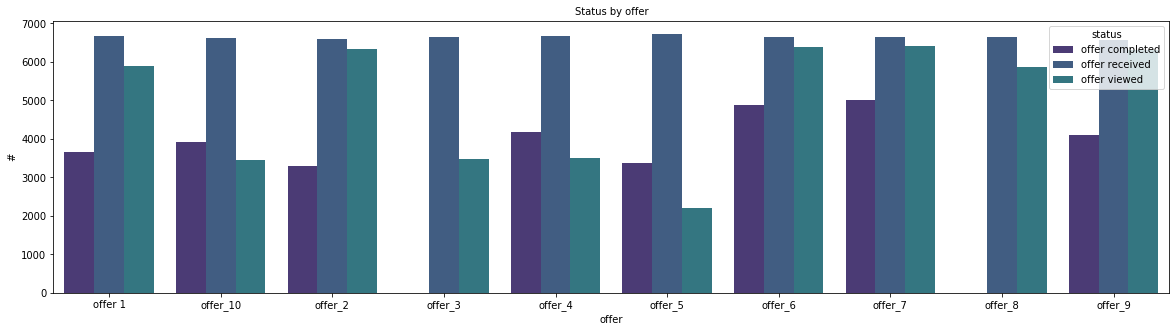

In [64]:
sns.set_palette("viridis")
offers_upv_gr = pd.DataFrame(offers_unpivot.groupby(['offer_desc','status']).count()['customerid']).reset_index()
plt.figure(figsize=(20, 5))
sns.barplot(x='offer_desc', y='customerid', hue='status', data=offers_upv_gr)
plt.title('Status by offer',size=10)
plt.xlabel('offer', size=10)
plt.ylabel('#',size=10)

#### 1.3.2. transaction dataset

In [65]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123957 entries, 12654 to 306532
Data columns (total 3 columns):
customerid    123957 non-null object
time          123957 non-null float64
amount        123957 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.8+ MB


In [66]:
print("transaction_data dataset contains {} variables and {} rows".format(transaction_data.shape[1],transaction_data.shape[0]))

transaction_data dataset contains 3 variables and 123957 rows


In [67]:
transaction_data.head()

,customerid,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [68]:
transaction_data.nunique()

customerid    14492
time            120
amount         5036
dtype: int64

- **`time` variable**

In [69]:
transaction_data.time.describe()

count    123957.000000
mean         15.886592
std           8.409545
min           0.000000
25%           8.750000
50%          16.750000
75%          23.000000
max          29.750000
Name: time, dtype: float64

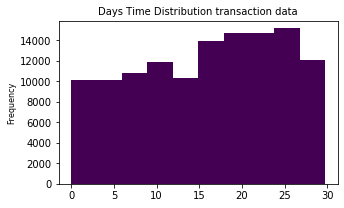

In [70]:
plt.title('Days Time Distribution transaction data', size=10)
plt.ylabel('Frecuency', size=8)
transaction_data.time.plot(kind='hist',cmap="viridis", figsize=(5, 3))

- **`amount` variable**

In [71]:
transaction_data.amount.describe()

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

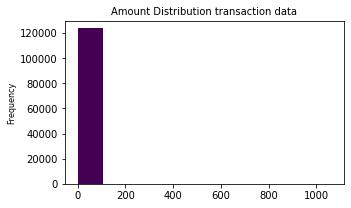

In [72]:
plt.title('Amount Distribution transaction data', size=10)
plt.ylabel('Frecuency', size=8)
transaction_data.amount.plot(kind='hist',cmap="viridis", figsize=(5, 3))

Due the outliers (like the 1062 value), plot looks like this

### 1.4. Combine portfolio, profile, offer and transaction data

For each customer, apply the following algorithm:

1. Select a customer's profile
2. Select offer data for a specific customer
3. Select transactions for a specific customer
4. Select received, completed, viewed offer data from customer offersr
5. Iterate over each offer a customer receives
6. Initialize the current offer id
7. Look-up a description of the current offer (duration_days)
8. Select the time when offer was received (start_time)
9. Calculate time when the offer ends (start_time + duration days)
10. Initialize boolean arrays that determine if the customer completed an offer between offer period, taking into account view and completed times.
11. Initialize a boolean array that select customer transactions that fall within the valid offer time window
12. Sum transactions amount per customer for all those transactions that within the valid offer time window
13. Convert combined data lists to dataframe

In [73]:
data = combine_data(profile_clean, portfolio_clean, offer_data, transaction_data)

In [74]:
data.head()

,100-110,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,...,weekda_bm_Wed,weekday_became_member,weekday_became_member_cat,year_became_member,year_bm_2013,year_bm_2014,year_bm_2015,year_bm_2016,year_bm_2017,year_bm_2018
0,0,0,0,0,0,0,0,1,0,0,...,0,1,Tue,2017,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,Tue,2017,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,Tue,2017,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,1,Tue,2017,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0,3,Thu,2018,0,0,0,0,0,1


In [75]:
print("data dataset contains {} variables and {} rows".format(data.shape[1],data.shape[0]))

data dataset contains 52 variables and 66501 rows


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 52 columns):
100-110                      66501 non-null int64
11-20                        66501 non-null int64
21-30                        66501 non-null int64
31-40                        66501 non-null int64
41-50                        66501 non-null int64
51-60                        66501 non-null int64
61-70                        66501 non-null int64
71-80                        66501 non-null int64
81-90                        66501 non-null int64
91-100                       66501 non-null int64
age                          66501 non-null int64
age_bins                     66501 non-null object
became_member_on             66501 non-null datetime64[ns]
channel_email                66501 non-null int64
channel_mobile               66501 non-null int64
channel_social               66501 non-null int64
channel_web                  66501 non-null int64
customerid                   66

#### 1.4.1. **% of success**

In [77]:
#groups by offerid all succesfull events
success_df = pd.DataFrame(data.groupby('offerid').sum()['offer_successful']).reset_index()
#groups by offerid all events
totals_df = pd.DataFrame(data.groupby('offerid')['customerid'].size()).reset_index()
#calculates the % of success based in the last two variables above
success_perc_df = pd.DataFrame(data.groupby('offerid').sum()['offer_successful']/data.groupby('offerid')['customerid'].size()).reset_index()

Text(0, 0.5, '% Success')

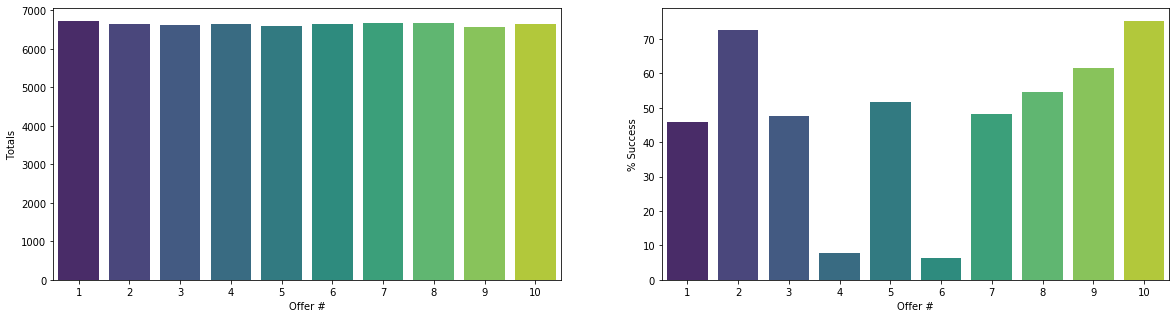

In [78]:
plt.figure(figsize = [20, 5])

# plot that illustrate how many customers were provided with a specific offer
plt.subplot(1, 2, 1)
ax = sns.barplot(x = totals_df.index + 1, y=totals_df.customerid, palette = 'viridis')
ax.set_xticks(np.arange(0,10))
ax.set_xlabel('Offer #')
ax.set_ylabel('Totals')

# plot that illustrate % of success by offer
plt.subplot(1, 2, 2)
ax = sns.barplot(x = success_perc_df.index + 1, y=success_perc_df[0]*100, palette = 'viridis')
ax.set_xticks(np.arange(0,10))
ax.set_xlabel('Offer #')
ax.set_ylabel('% Success')

#### 1.4.2.  **Customer statistics**

**a. Avg income**

Text(0, 0.5, 'Avg Income')

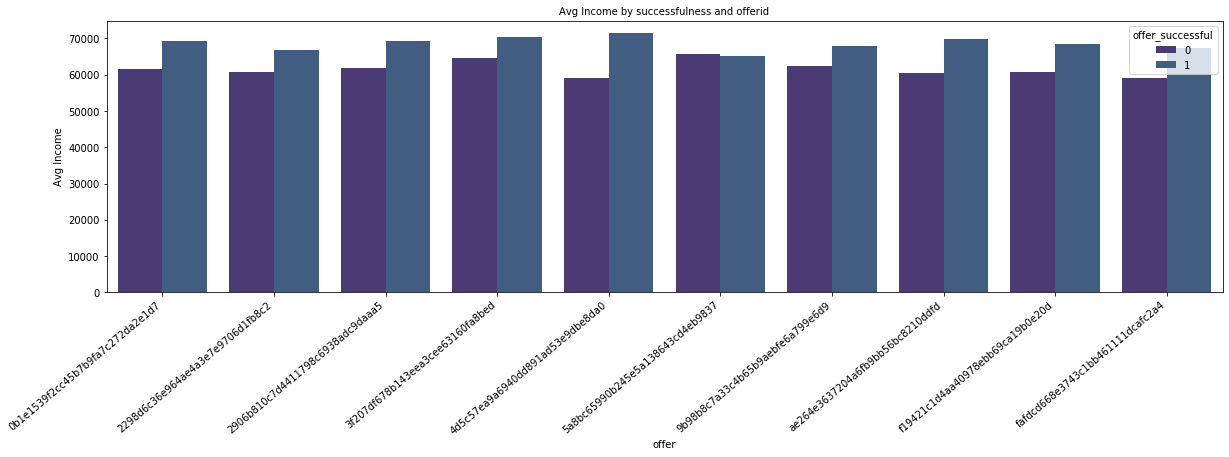

In [79]:
avg_inc = pd.DataFrame(data.groupby(['offer_successful','offerid']).mean()['income']).reset_index()
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='offerid', y='income', hue='offer_successful', data=avg_inc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Avg Income by successfulness and offerid',size=10)
plt.xlabel('offer', size=10)
plt.ylabel('Avg Income',size=10)

In [80]:
#detail table with % of difference between successfull and unsuccessfull events 
table_avg_inc = pd.pivot_table(avg_inc, values = 'income', index=['offerid'], columns = 'offer_successful').reset_index()
table_avg_inc = table_avg_inc.rename(columns={0: 'unsuccessful',1: 'successful','offer_successful': 'index'})
table_avg_inc['diff %'] = ((table_avg_inc.successful - table_avg_inc.unsuccessful)/table_avg_inc.unsuccessful)*100

In [81]:
table_avg_inc

offer_successful,offerid,unsuccessful,successful,diff %
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61648.574561,69364.522417,12.516020
1,2298d6c36e964ae4a3e7e9706d1fb8c2,60796.030871,66888.865937,10.021765
2,2906b810c7d4411798c6938adc9daaa5,61972.590883,69295.734597,11.816746
3,3f207df678b143eea3cee63160fa8bed,64744.912909,70400.778210,8.735613
4,4d5c57ea9a6940dd891ad53e9dbe8da0,59177.505498,71370.674487,20.604398
5,5a8bc65990b245e5a138643cd4eb9837,65588.821073,65165.467626,-0.645466
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,62470.350014,68030.978934,8.901229
7,ae264e3637204a6fb9bb56bc8210ddfd,60414.054767,69844.468784,15.609636
8,f19421c1d4aa40978ebb69ca19b0e20d,60774.564184,68432.872655,12.601174
9,fafdcd668e3743c1bb461111dcafc2a4,59116.788321,67465.055911,14.121653


Higher incomes for successful events


**b. Avg Age**

Text(0, 0.5, 'Avg Income')

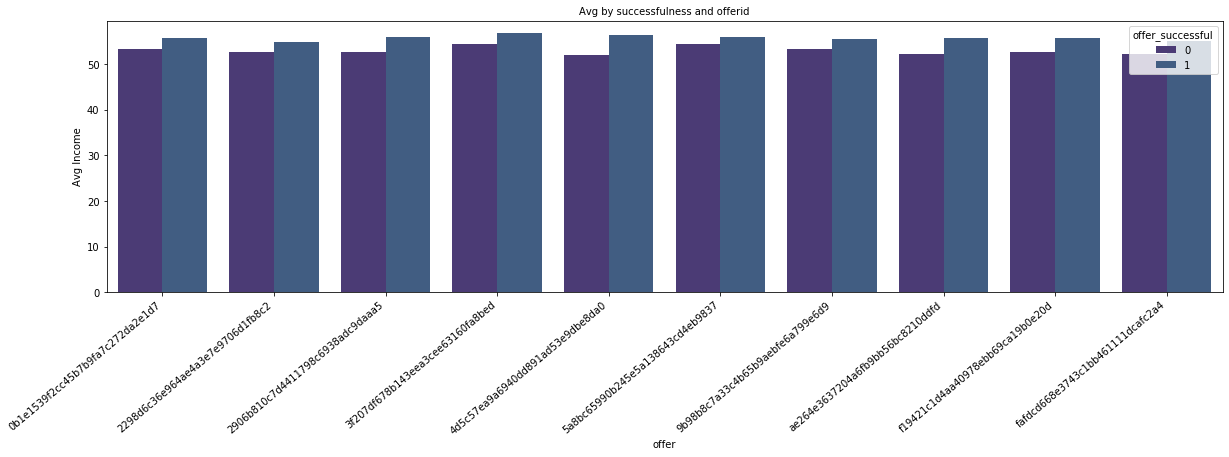

In [82]:
avg_age = pd.DataFrame(data.groupby(['offer_successful','offerid']).mean()['age']).reset_index()
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='offerid', y='age', hue='offer_successful', data=avg_age)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Avg by successfulness and offerid',size=10)
plt.xlabel('offer', size=10)
plt.ylabel('Avg Income',size=10)

In [83]:
#detail table with difference of years between successfull and unsuccessfull events 
table_avg_age = pd.pivot_table(avg_age, values = 'age', index=['offerid'], columns = 'offer_successful').reset_index()
table_avg_age = table_avg_age.rename(columns={0: 'unsuccessful',1: 'successful','offer_successful': 'index'})
table_avg_age['diff years'] = table_avg_age.successful - table_avg_age.unsuccessful

In [84]:
table_avg_age

offer_successful,offerid,unsuccessful,successful,diff years
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,53.204221,55.777128,2.572907
1,2298d6c36e964ae4a3e7e9706d1fb8c2,52.724917,54.848792,2.123874
2,2906b810c7d4411798c6938adc9daaa5,52.578765,55.934281,3.355516
3,3f207df678b143eea3cee63160fa8bed,54.382549,56.694553,2.312003
4,4d5c57ea9a6940dd891ad53e9dbe8da0,51.996544,56.413783,4.417239
5,5a8bc65990b245e5a138643cd4eb9837,54.461934,56.002398,1.540464
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,53.342204,55.483581,2.141377
7,ae264e3637204a6fb9bb56bc8210ddfd,52.262950,55.806681,3.543732
8,f19421c1d4aa40978ebb69ca19b0e20d,52.646197,55.614018,2.967821
9,fafdcd668e3743c1bb461111dcafc2a4,52.160584,55.148163,2.987579


Elder people for successful events


**c. Gender**

In [85]:
# % Succesfullness by gender overview
tets = pd.DataFrame(data.groupby(['offer_type']).mean()['offer_successful']*100).reset_index()
tets = tets.rename(columns={'offer_successful': '% successful events'})
tets

,offer_type,% successful events
0,bogo,54.045295
1,discount,60.351035
2,informational,7.000000


In [86]:
# % Succesfullness by gender overview
succes_gen = pd.DataFrame(data.groupby(['gender']).mean()['offer_successful']*100).reset_index()
succes_gen = succes_gen.rename(columns={'offer_successful': '% successful events'})
succes_gen

,gender,% successful events
0,F,53.114073
1,M,42.678801
2,O,55.567686


Text(0, 0.5, '% Succesfull')

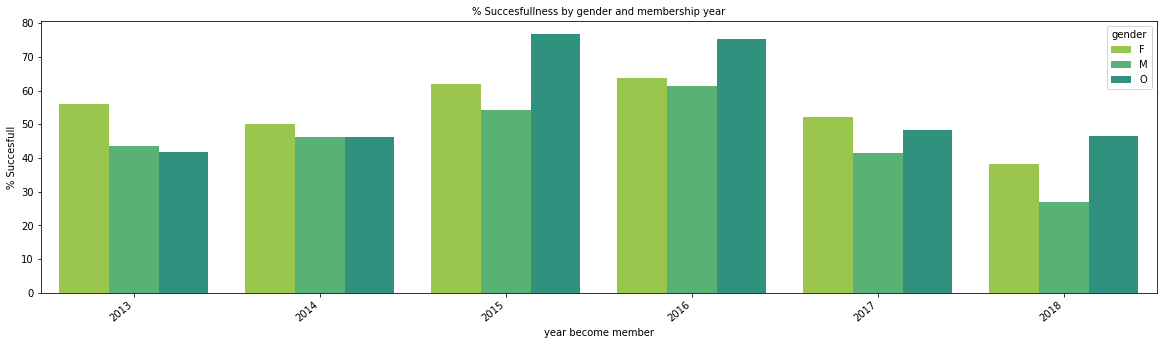

In [87]:
# % Succesfullness by gender and membership year
succes_gen_year = pd.DataFrame(data.groupby(['gender','year_became_member']).mean()['offer_successful']*100).reset_index()
succes_gen_year = succes_gen_year.rename(columns={'offer_successful': '% successful events'})

sns.set_palette("viridis_r")
plt.figure(figsize=(20, 5))
ax = sns.barplot(x='year_became_member', y='% successful events', hue='gender', data=succes_gen_year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('% Succesfullness by gender and membership year',size=10)
plt.xlabel('year become member', size=10)
plt.ylabel('% Succesfull',size=10)

- Women have the best ratio of succesful events
- People who became member in 2015 and 2016 have much better % of succesful ratios

**d. Date**

In [88]:
success_week_day = pd.DataFrame(data.groupby(['weekday_became_member_cat']).mean()['offer_successful']*100).reset_index()
success_week_day = success_week_day.rename(columns={'offer_successful': '% successful events'})
success_week_day

,weekday_became_member_cat,% successful events
0,Fri,48.418111
1,Mon,47.144420
2,Sat,46.060114
3,Sun,47.126320
4,Thu,46.834919
5,Tue,46.883303
6,Wed,47.830779


Weekday you became member don't impact in % successfullness of evens. Let's see in a heatmap if there seasonality affects to this kpi:

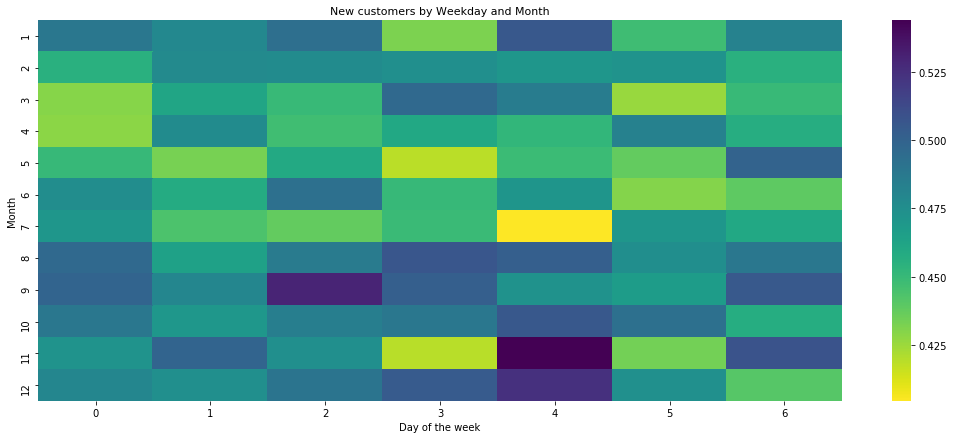

In [89]:
success_day_month = pd.DataFrame(data.groupby(['month_became_member', 'weekday_became_member']).mean()['offer_successful']).reset_index()
success_day_month = success_day_month.pivot('month_became_member','weekday_became_member','offer_successful')


plt.figure(figsize=(18,7))
sns.heatmap(success_day_month, cmap = 'viridis_r')
plt.title('New customers by Weekday and Month', size=11)
plt.ylabel('Month', size=10)
plt.xlabel('Day of the week', size=10)
plt.show()

Fridays on November and December have higher %

**e. Offer_type analysis**

In [90]:
# % Succesfullness by offertype overview
offer_type_success = pd.DataFrame(data.groupby(['offer_type']).mean()['offer_successful']*100).reset_index()
offer_type_success = tets.rename(columns={'offer_successful': '% successful events'})
offer_type_success

,offer_type,% successful events
0,bogo,54.045295
1,discount,60.351035
2,informational,7.000000


Informational offers have a very low succesfull rate

**f. Offer duration analysis**

In [91]:
# % Succesfullness by offer duration overview
duration_success = pd.DataFrame(data.groupby(['duration']).mean()['offer_successful']*100).reset_index()
duration_success = duration_success.rename(columns={'offer_successful': '% successful events'})
duration_success

,duration,% successful events
0,3,6.277284
1,4,7.721196
2,5,56.663376
3,7,55.849028
4,10,60.442518


The more time an offer is available, the more % of success

**g. Offer reward analysis**

In [92]:
# % Succesfullness by offer duration overview
reward_success = pd.DataFrame(data.groupby(['reward']).mean()['offer_successful']*100).reset_index()
reward_success = reward_success.rename(columns={'offer_successful': '% successful events'})
reward_success

,reward,% successful events
0,0,7.000000
1,2,61.529775
2,3,72.742299
3,5,51.823685
4,10,53.193733


Offer with rewards impact in a positive way in successfullness rate

Let's now compare reward vs duration

In [93]:
bubble_reward_duration = data.groupby(['reward','duration']).mean()[['offer_successful']].reset_index()
bubble_reward_duration

,reward,duration,offer_successful
0,0,3,0.062773
1,0,4,0.077212
2,2,7,0.477304
3,2,10,0.752856
4,3,7,0.727423
5,5,5,0.616180
6,5,7,0.482872
7,5,10,0.457627
8,10,5,0.517215
9,10,7,0.546461


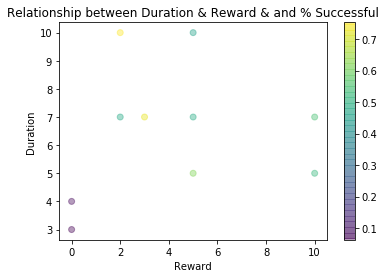

In [94]:
x = bubble_reward_duration.reward
y = bubble_reward_duration.duration
t = bubble_reward_duration.offer_successful

x = plt.scatter( x, y, c=t, alpha=0.4,cmap = 'viridis')
plt.xlabel('Reward')
plt.ylabel('Duration')
plt.title('Relationship between Duration & Reward & and % Successful')
plt.colorbar()

Higher succesfull rates for those offers that have little reward (2,3) but enough time to complete it (> 7 days)

**g. Offer difficulty analysis**

In [95]:
# % Succesfullness by offer difficult overview
reward_dff = pd.DataFrame(data.groupby(['difficulty']).mean()['offer_successful']*100).reset_index()
reward_dff = reward_dff.rename(columns={'offer_successful': '% successful events'})
reward_dff

,difficulty,% successful events
0,0,7.000000
1,5,54.897821
2,7,72.742299
3,10,57.362853
4,20,45.762712


Mid difficulty offers for better successfull ratios

**h. Multivariable analysis**

Relation between average Income ($), Avg Age (years), % succesfull and offerid

In [96]:
bubble_offer = data.groupby('offerid').mean()[['offer_successful','age','income']].reset_index()
bubble_offer

,offerid,offer_successful,age,income
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.457627,54.381653,65179.601546
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.727423,54.269872,65228.099174
2,2906b810c7d4411798c6938adc9daaa5,0.477304,54.180365,65467.953552
3,3f207df678b143eea3cee63160fa8bed,0.077212,54.561064,65181.613339
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.517215,54.281207,65483.998180
5,5a8bc65990b245e5a138643cd4eb9837,0.062773,54.558633,65562.245973
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.482872,54.376215,65155.422588
7,ae264e3637204a6fb9bb56bc8210ddfd,0.546461,54.199461,65567.409846
8,f19421c1d4aa40978ebb69ca19b0e20d,0.616180,54.474909,65493.461071
9,fafdcd668e3743c1bb461111dcafc2a4,0.752856,54.409802,65401.834035


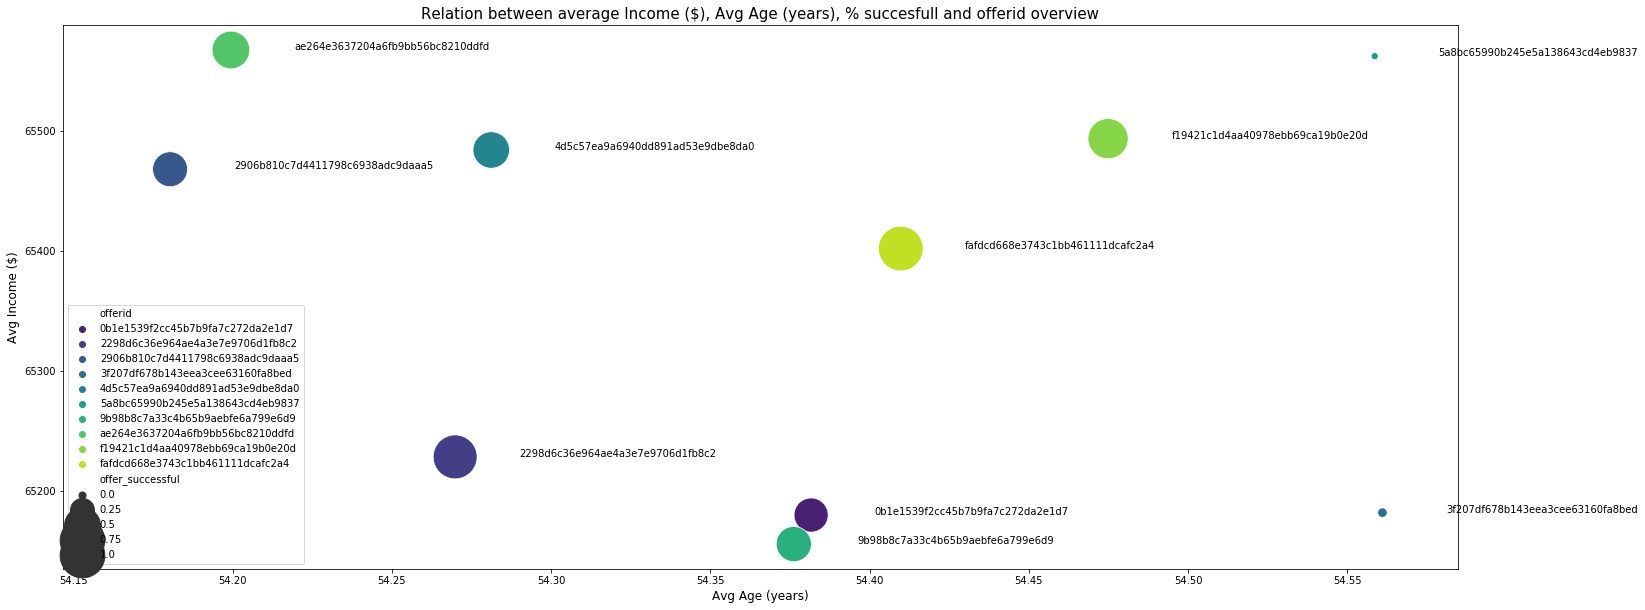

In [97]:
# Relation between average Income ($), Avg Age (years), % succesfull and offerid
plt.figure(figsize=(25,10))

sns.scatterplot(x='age',y='income',hue='offerid',size='offer_successful',sizes=(50, 2000),palette='viridis',data=bubble_offer)
plt.title('Relation between average Income ($), Avg Age (years), % succesfull and offerid overview', size=15)
plt.ylabel('Avg Income ($)', size=12)
plt.xlabel('Avg Age (years)', size=12)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(bubble_offer.age, bubble_offer.income, bubble_offer.offerid, plt.gca()) 

Let's see now the behaviour of the graph above taking into account genders:

In [98]:
bubble_offer_men = data[data['gender_M'] == 1].groupby('offerid').mean()[['offer_successful','age','income']].reset_index()
bubble_offer_women = data[data['gender_F'] == 1].groupby('offerid').mean()[['offer_successful','age','income']].reset_index()

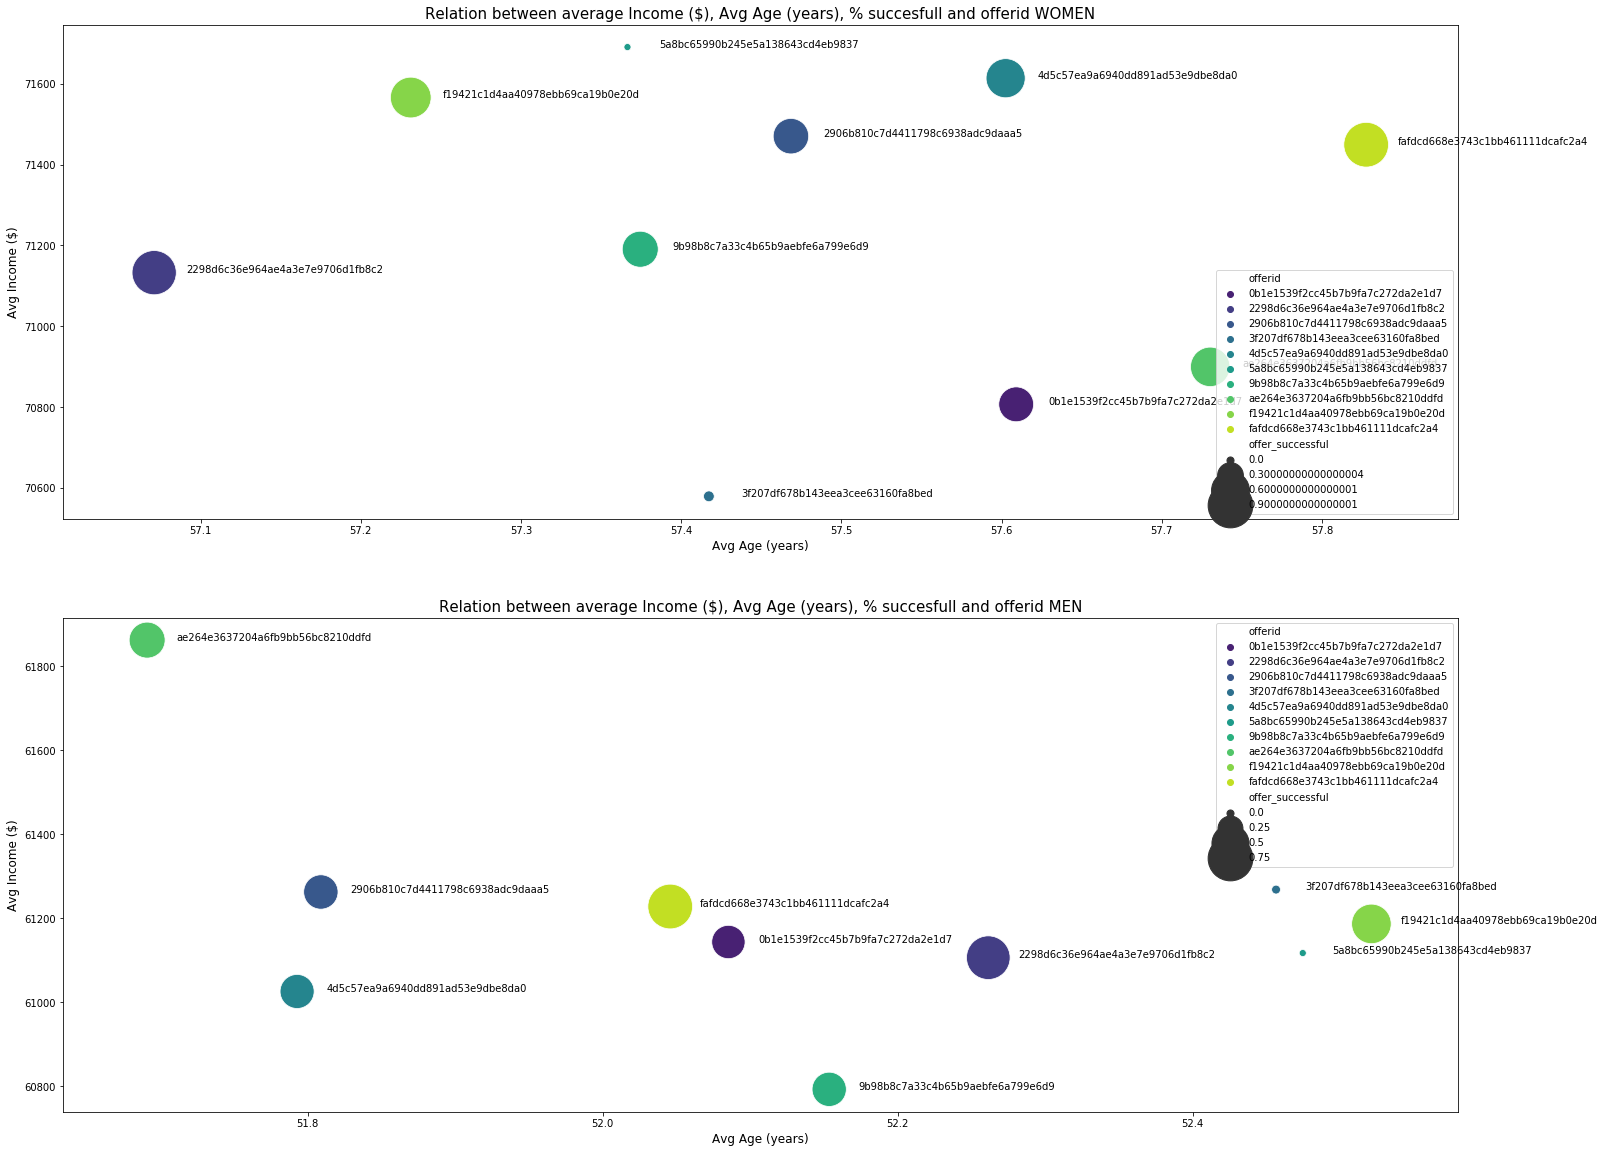

In [99]:
sns.set_palette("viridis_r")
plt.figure(figsize=(25,20))

plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
axes = plt.gca()

ax = sns.scatterplot(x='age',y='income',hue='offerid',size='offer_successful',sizes=(50, 2000),palette='viridis',data=bubble_offer_women)
plt.title('Relation between average Income ($), Avg Age (years), % succesfull and offerid WOMEN', size=15)
plt.ylabel('Avg Income ($)', size=12)
plt.xlabel('Avg Age (years)', size=12)

label_point(bubble_offer_women.age, bubble_offer_women.income, bubble_offer_women.offerid, plt.gca()) 

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
axes = plt.gca()

ax = sns.scatterplot(x='age',y='income',hue='offerid',size='offer_successful',sizes=(50, 2000),palette='viridis',data=bubble_offer_men)
plt.title('Relation between average Income ($), Avg Age (years), % succesfull and offerid MEN', size=15)
plt.ylabel('Avg Income ($)', size=12)
plt.xlabel('Avg Age (years)', size=12)

label_point(bubble_offer_men.age, bubble_offer_men.income, bubble_offer_men.offerid, plt.gca()) 

plt.show()

## 2. Build Models

### 2.1. Create train and test datasets

To predict if a offer is succesfull we have to split data df into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset in order to test our model's prediction on this subset.

In [100]:
# show the columns of the combined datset 
data.columns

Index(['100-110', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100', 'age', 'age_bins', 'became_member_on',
       'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
       'customerid', 'difficulty', 'duration', 'gender', 'gender_F',
       'gender_M', 'gender_O', 'income', 'month_became_member',
       'month_became_member_cat', 'offer_bogo', 'offer_discount',
       'offer_informational', 'offer_successful', 'offer_type', 'offerid',
       'reward', 'time', 'total_amount', 'weekda_bm_Fri', 'weekda_bm_Mon',
       'weekda_bm_Sat', 'weekda_bm_Sun', 'weekda_bm_Thu', 'weekda_bm_Tue',
       'weekda_bm_Wed', 'weekday_became_member', 'weekday_became_member_cat',
       'year_became_member', 'year_bm_2013', 'year_bm_2014', 'year_bm_2015',
       'year_bm_2016', 'year_bm_2017', 'year_bm_2018'],
      dtype='object')

In [101]:
# Drop variables from combined_data which are not required for training the model
data_df = data.drop(columns=['age', 'age_bins', 'became_member_on', 'customerid','gender','offerid',
                             'month_became_member', 'month_became_member_cat', 'time',
                             'year_became_member', 'offer_type','weekda_bm_Fri',
                             'weekda_bm_Mon','weekda_bm_Sat', 'weekda_bm_Sun', 'weekda_bm_Thu', 'weekda_bm_Tue',
                              'weekda_bm_Wed', 'weekday_became_member', 'weekday_became_member_cat'])

In [102]:
data_df.head()

,100-110,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,...,offer_informational,offer_successful,reward,total_amount,year_bm_2013,year_bm_2014,year_bm_2015,year_bm_2016,year_bm_2017,year_bm_2018
0,0,0,0,0,0,0,0,1,0,0,...,0,1,5,37.67,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,49.39,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,10,48.28,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,1,5,48.28,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,2,0.00,0,0,0,0,0,1


In [103]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 32 columns):
100-110                66501 non-null int64
11-20                  66501 non-null int64
21-30                  66501 non-null int64
31-40                  66501 non-null int64
41-50                  66501 non-null int64
51-60                  66501 non-null int64
61-70                  66501 non-null int64
71-80                  66501 non-null int64
81-90                  66501 non-null int64
91-100                 66501 non-null int64
channel_email          66501 non-null int64
channel_mobile         66501 non-null int64
channel_social         66501 non-null int64
channel_web            66501 non-null int64
difficulty             66501 non-null int64
duration               66501 non-null int64
gender_F               66501 non-null int64
gender_M               66501 non-null int64
gender_O               66501 non-null int64
income                 66501 non-null float64
offer_bog

In [104]:
#split data into features X and target y
# features : independece variables that act as the input of the model
X = data_df.drop(columns=['offer_successful'])
# target : the variable to predict 
y = data_df['offer_successful']

In [105]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.2. Scale features

In [106]:
features_to_scale = ['difficulty', 'duration', 'reward', 'income', 'total_amount']

In [107]:
def features_scale(df, feat=features_to_scale):
    
    
    """
    Scale list features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        
    # Prepare dataframe with features to scale
    df_feat_scale = df[feat]
        
    # Apply feature scaling to df
    scaler = MinMaxScaler()
    df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,index=df_feat_scale.index)
        
    # Drop orignal features from df and add scaled features 
    df = df.drop(columns=feat, axis=1)
    df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
    return df_scaled

In [108]:
# Scale selected features in training set i.e. X_train
X_train_scaled = features_scale(X_train, feat=features_to_scale)
X_train_scaled.head()

,100-110,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,...,year_bm_2014,year_bm_2015,year_bm_2016,year_bm_2017,year_bm_2018,difficulty,duration,reward,income,total_amount
58908,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0.50,1.000000,0.2,0.822222,0.0
19120,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0.50,1.000000,0.2,0.811111,0.0
28550,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.25,0.571429,0.5,0.077778,0.0
33970,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0.50,0.571429,1.0,0.311111,0.0
50388,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0.50,0.285714,1.0,0.522222,0.0


In [109]:
y_train.mean()

0.4707626208378088

From the results shown above, we can observe that our training dataset is nearly balanced, it has nearly equal number of customers whom responded to an offer (47%) and customers whom did not responded to an offer (53%). Since, our training dataset is nearly balanced, we do not have to deal with techniques to combat class imbalance.

In [110]:
y_test.mean()

0.47371059094782214

From the results shown above, we can observe that our testing dataset is also nearly balanced.

### 2.2 Train classifier

_Select the appropriate performance matrix_ <br>
We found that our training data is nearly balanced in terms of distribution of target class, performance metrics like precision, recall, and f1_score are perfect measures for evaluating a model. F1-score metric is "the harmonic mean of the precision and recall metrics" and is better way of providing greater predictive power on the problem and how good the predictive model is making predictions.

In [111]:
def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):

    """
    Fits a classifier to its training data using GridSearchCV and calculates f1_score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train_scaled (DataFrame): training features
    - y_train (DataFrame): training label

    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [112]:
# Initialize classification algorithms
lr = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier

In [113]:
# Find best classification algorithm
cl_names = []
cl_scores = []
cl_best_ests = []
cl_time_taken = []
cl_dict = {}

for classifier in [lr, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(classifier, {})
    cl_names.append(classifier.__class__.__name__)
    cl_scores.append(best_score)
    cl_best_ests.append(best_est)
    cl_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 2.25 secs
Best f1_score : 0.7153
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 2.32 secs
Best f1_score : 0.6541
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 10.35 secs
Best f1_score : 0.718
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 29.85 secs
Best f1_score : 0.7205
****************************************


GradientBoostingClassifier has the best f1 score

In [114]:
# Create clf_df dataframe from clf_dict
cl_dict['best_f1_score'] = cl_scores
cl_dict['time_taken(s)'] = cl_time_taken
cl_dict['best_est'] = cl_best_ests
cl_df = pd.DataFrame(cl_dict, index=cl_names)
cl_df

,best_f1_score,time_taken(s),best_est
LogisticRegression,0.715318,2.25,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.654098,2.32,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.717972,10.35,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.720467,29.85,([DecisionTreeRegressor(criterion='friedman_ms...


In [115]:
# display parameters of GradientBoostingClassifier
cl_df.loc['GradientBoostingClassifier', 'best_est']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [116]:
# Tuning GradientBoostingClassifier  classifier with the help of param grid in GridSearchCV
param_grid = {
#                 'max_depth': [3, 4],
#                 'learning_rate': [0.1, 0.5, 1],
                'min_samples_leaf': [1, 2],
                'min_samples_split': [2, 3],
                'n_estimators': [25, 50, 100]}

gbc = GradientBoostingClassifier(random_state=42)
gbc_best_score, gbc_best_est, _ = fit_classifier(gbc, param_grid)
gbc_best_est

Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 245.1 secs
Best f1_score : 0.7243
****************************************


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=25,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 2.4 Feature importance by GradientBoostingClassifier 

In [117]:
# Prepare a dataframe with features and their importance by GradientBoostingClassifier
feature_imp = pd.DataFrame(gbc_best_est.feature_importances_,index=X_train_scaled.columns.tolist(),columns=['feat_imp']).reset_index()

feature_imp.rename(columns={'index': 'feature'}, inplace=True)
feature_imp['feat_imp_rate'] = np.round((feature_imp['feat_imp']/feature_imp['feat_imp'].sum())*100,2)
feature_imp = feature_imp.sort_values(by=['feat_imp_rate'], ascending=False).reset_index(drop=True)
feature_imp.drop(columns=['feat_imp'],inplace=True)
feature_imp

,feature,feat_imp_rate
0,offer_informational,23.19
1,duration,20.61
2,year_bm_2018,11.62
3,difficulty,11.38
4,income,7.10
5,channel_social,6.83
6,year_bm_2016,6.67
7,reward,5.76
8,gender_M,2.63
9,offer_discount,2.31


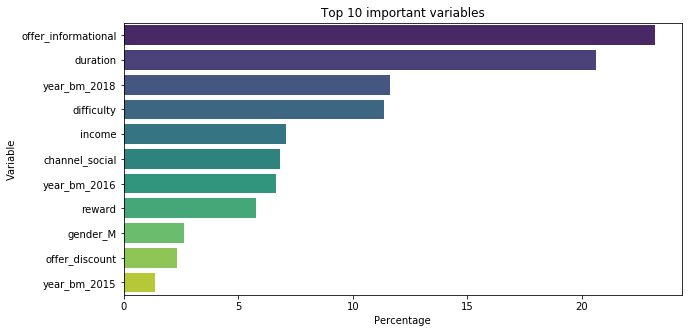

In [118]:
# Plot bar chart of variables with their importance
fig, ax = plt.subplots(figsize=(10, 5),nrows=1,ncols=1)
sns.barplot(x=feature_imp.loc[0:10,'feat_imp_rate'], y=feature_imp.loc[0:10,'feature'], palette="viridis", data=feature_imp)
plt.xlabel('Percentage')
plt.ylabel('Variable')
plt.title('Top 10 important variables')
plt.show()

From the results shown above we notice that :

Top 10 features which influence whether the customer will respond to an offer or not after viewing the offer are:

- `offer_informational`: refers to offer types that bring customers information. As seen in Customer's statistics, this type of offer has only a 7% of successful rate, which means that this kind of campaigns do not have good successful rates <br><br>

- `difficulty`: minimum required spend to complete an offer- As seen in Customer's statistics, mid difficulty offers for better successfull ratios<br><br>

- `duration`: variable which represents, how long the offer is valid by the customer response and completion of the offer. As seen in Customer's statistics, the more time an offer is available, the more % of success<br><br>

- `year_bm_2018`: variable, that represents if a customer became member of Starbucks reward program in years 2018<br><br>

- `income` customer's income. Higher incomes impact in a positive way when completing an offer<br><br>

- `channel_social` if Starbucks sent the offer to customer via social media is likely to be responded more that other mode of communication<br><br>

- `year_bm_2016`: variable, that represents if a customer became member of Starbucks reward program in years 2016<br><br>

- `reward`: variable which represents reward given for completing an offer<br><br>

- `gender_M`: men have 20% less of successful rates than women (42% vs 53%) <br><br>

- `offer_discount`: refers to offer types that give discounts to customers. As seen in Customer's statistics, this type of offer has a good 60% of successful rate, which means that this kind of campaigns have good successful rates<br><br>

- `year_bm_2015`: variable, that represents if a customer became member of Starbucks reward program in year 2015<br><br>

### 2.5. Predict test data

In [119]:
# Scale selected features in test data
X_test_scaled = features_scale(X_test, feat=features_to_scale)
X_test_scaled.head()

,100-110,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,...,year_bm_2014,year_bm_2015,year_bm_2016,year_bm_2017,year_bm_2018,difficulty,duration,reward,income,total_amount
20034,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0.25,0.571429,0.5,0.211111,0.0
55752,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0.50,0.571429,1.0,0.266667,0.0
61495,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0.25,0.285714,0.5,0.222222,0.0
34391,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0.25,0.285714,0.5,0.055556,0.0
36619,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0.25,0.285714,0.5,0.133333,0.0


In [120]:
# Classification of test data using best model trained on train data
predictions = gbc_best_est.predict(X_test_scaled)
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

**Confusion Matrix**

In [121]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, predictions)

array([[7212, 3288],
       [2191, 7260]], dtype=int64)

In [122]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, predictions).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 7212
false postives: 3288
false negatives: 2191
true postives: 7260


In [123]:
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.viridis_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    - y_true (np.array): array containing true labels
    - y_pred (np.array): array containing predicted labels
    - normalize (boolean): boolean value to determine whether to normalize the confusion matrix or not
    - title (str): title to use in confusion matrix plot
            
    OUTPUT:
    - ax (Axes object): Axes object to plot confusion matrix plot
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', alpha = 0.6, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[7212 3288]
 [2191 7260]]


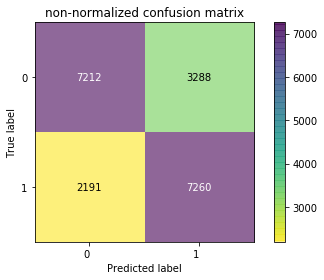

In [124]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
class_names = np.array([0, 1])
plot_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names,title='non-normalized confusion matrix')

Normalized confusion matrix
[[0.69 0.31]
 [0.23 0.77]]


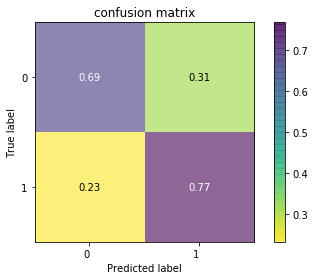

In [125]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names, normalize=True,title='confusion matrix')

As we can see in the matrix above, results shows that a 24% is misclassifying customer acceptance for an offer, and a 28% misclassifying customer refusal for an offer. FN is less than FP which is good news, though the model accuracy could be better. 

As Starbucks would not like to miss sending offers to individuals who would respond, this model could be suitable for this case

### Conclusion

The problem that I choose to solve was to build a model that predicts whether a customer will respond to an offer. These are the steps taken to achieve this:
1. Analyze and preprocess portfolio, profile and transaction datasets
2. Combine these clean datasets containing relevant features which can be used to train our model
3. Split data to train and test datasets, choosing as best estimator "GradientBoostingClassifier" using GridSearch which is the best performing classifier algorithm among the above 4 classifiers tested (comparing F1-score)
4. Predict test target using test data, and plot a confusion matrix to ensure the performance of the model, founding that our predictive model is well suited for this case.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A Gradient Boosting Classifier is an example of a model that estimates feature importance during training. My analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top five features based on their importance are:

- Informational offers
- Offer difficulty (how much money a customer must spend to complete an offer)
- Offer duration
- Whether a customer created an account on the Starbucks rewards mobile application in 2018
- Customer's income

Since the 4 of the top 5 features are associated with an customer offer, it may be possible to improve the performance of a Gradient Boosting Classifier by creating features that describe an offer's success rate as a function of offer difficulty, duration or reward.

**Improvements**

- Datasets had limited number of variables. More features could've produced even better results such as demographic variables, geographical location, marital status...

- At first sight, it seemed like we had a lot of data to work, but once NaN values and duplicate columns were dropped